# Text Classification Model for Ubuntu Customer Centre Inquiries

## Project Overview

The objective of this project is to develop a **text classification model** that can accurately categorize Ubuntu Customer Centre inquiries into distinct topics or categories. 

### Dataset
- **Size:** Approximately 150,000 customer inquiries
- **Subset:** You may choose to work with a subset of this data

### Goals
- **Develop a robust model** for text classification
- **Achieve decent accuracy** in categorizing inquiries
- **Identify at least 5 distinct topics** or categories from the data

### Note:
- You are allowed to use any relevant open-source libraries or frameworks.
- Consider utilizing techniques to address challenges such as class imbalance, overfitting, or handling long or noisy texts.
- Feel free to explore and experiment with different approaches or improvements beyond the initial project requirements.
- Don’t use any existing OSS models or any LLM to do the classification


## Installation of certain libraries & frameworks

- from requirements.txt

create a virtual environment and use that environment as workspace

In [65]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import of certain libraries & frameworks

In [66]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Pre Label Modelling Engineering

#### Loading and observing given dataset

In [67]:
df = pd.read_csv('inquaries.csv') 
df.dropna(subset=['inquiry'], inplace=True)
print(df.head())

   sno                                            inquiry
0    0  Hello folks, please help me a bit with the fol...
1    1  is there any reason why my 'network manager' i...
2    2  I installed the 64bit version of ubuntu and I ...
3    3  Hello Does Ubuntu have somekind of register to...
4    4  anyone else run into issues with cd/dvd burner...


#### Vectorization and Text featuring

In [68]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df['inquiry'])

In [69]:
count_vectorizer = CountVectorizer(stop_words='english')
X_cntvec = count_vectorizer.fit_transform(df['inquiry'])

### Step:1 Labelling of dataset
Here we are taking to approached -
1. Clustering approach to label the data
2. Topic Modelling approach to label the data

### Method 1: Performing Clustering for assigning classes to each row (K means)

In [70]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)
df['class_kmeans'] = kmeans.labels_
print(df.head())

   sno                                            inquiry  class_kmeans
0    0  Hello folks, please help me a bit with the fol...             4
1    1  is there any reason why my 'network manager' i...             0
2    2  I installed the 64bit version of ubuntu and I ...             1
3    3  Hello Does Ubuntu have somekind of register to...             1
4    4  anyone else run into issues with cd/dvd burner...             4


In [71]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.cluster_centers_):
        print(f"class {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

n_top_words = 15
print_top_words(kmeans, tfidf_vectorizer.get_feature_names_out(), n_top_words)

class 0:
change ubuntu resolution default know screen file permissions way hi want root does user need
class 1:
ubuntu windows does hi know installed help just use like server boot 04 way hello
class 2:
install ubuntu apt package cd trying need hi want just help installed know way windows
class 3:
10 04 ubuntu 11 upgrade install hi installed just help using know does update hello
class 4:
know does help use file hi just linux way command like need using files hey


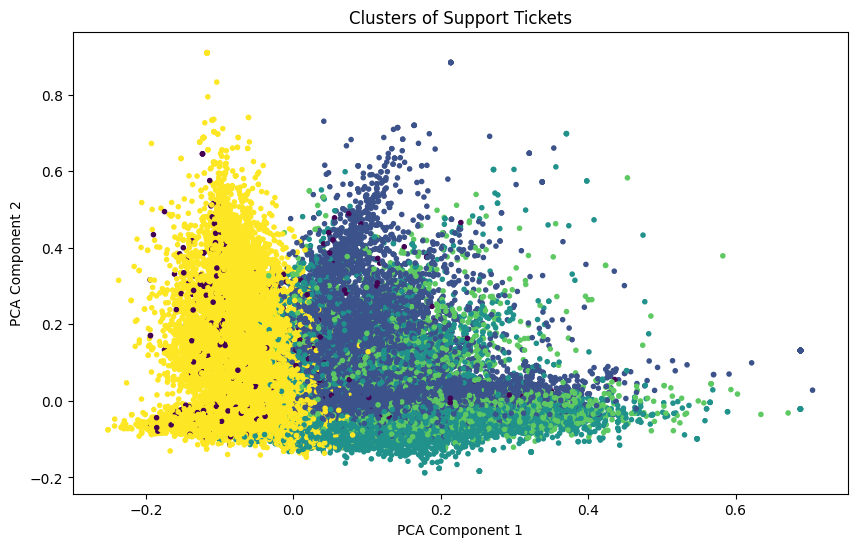

In [72]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='.')
plt.title('Clusters of Support Tickets')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### Method 2(a): Performing Topic Modelling for assigning classes to each row (LDA)

In [74]:
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X_cntvec)
topic_distribution = lda.transform(X_cntvec)
df['class_lda'] = topic_distribution.argmax(axis=1)
print(df.head())

   sno                                            inquiry  class_kmeans  \
0    0  Hello folks, please help me a bit with the fol...             4   
1    1  is there any reason why my 'network manager' i...             0   
2    2  I installed the 64bit version of ubuntu and I ...             1   
3    3  Hello Does Ubuntu have somekind of register to...             1   
4    4  anyone else run into issues with cd/dvd burner...             4   

   class_lda  
0          3  
1          2  
2          2  
3          2  
4          3  


In [75]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"class {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_top_words = 15
display_topics(lda, count_vectorizer.get_feature_names_out(), no_top_words)

class 0:
command file know files terminal does use hi way user program like server want run
class 1:
install ubuntu installed apt package just hi like gnome kernel packages version help know does
class 2:
ubuntu 10 04 help just screen know card hi work does problem wireless using installed
class 3:
ubuntu windows drive partition boot linux install cd use usb way want know mount hard
class 4:
error sound help http problem trying ip com conf getting file try xorg work ubuntu


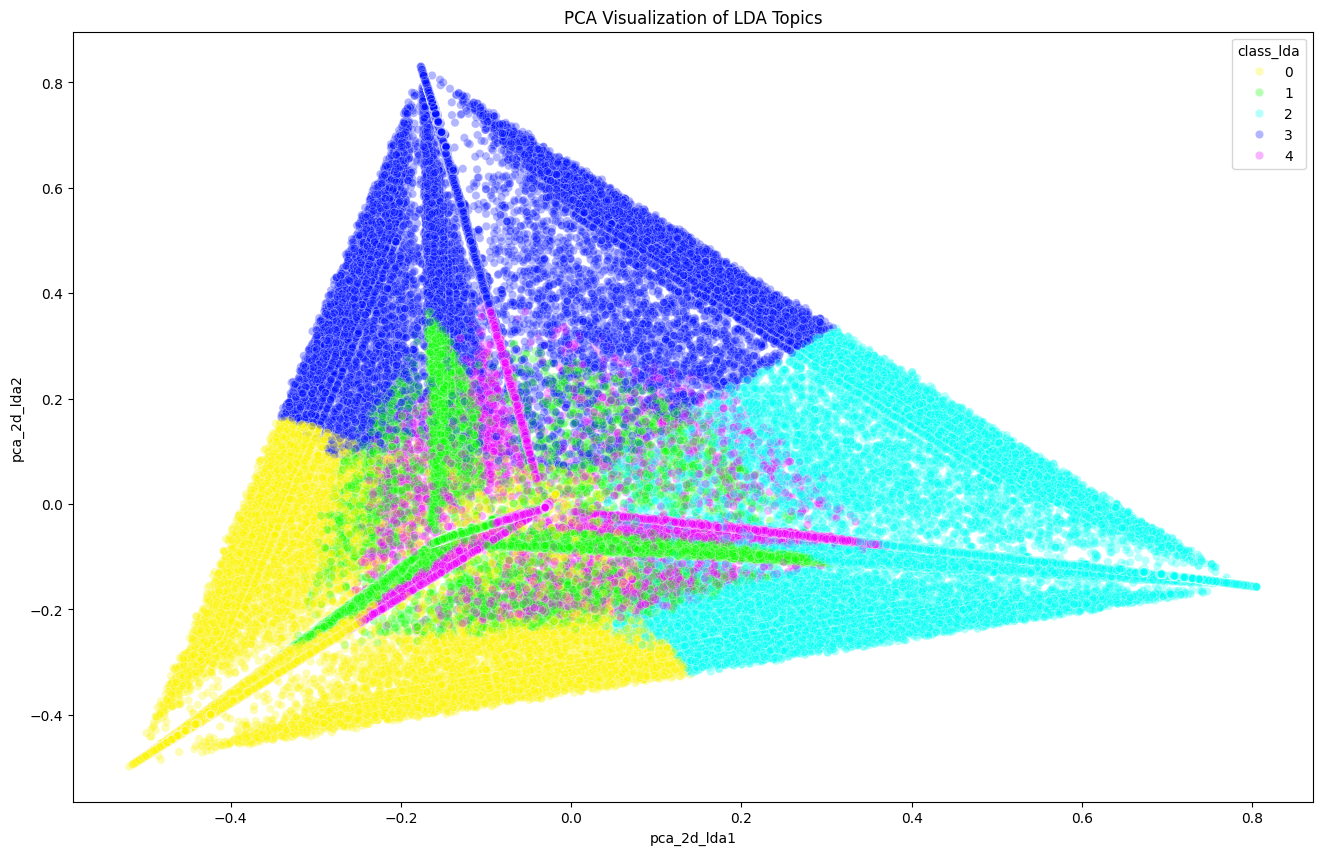

In [76]:
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(topic_distribution)

# Add the PCA results and topic assignments to the dataframe
df['pca_2d_lda1'] = pca_results[:, 0]
df['pca_2d_lda2'] = pca_results[:, 1]
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca_2d_lda1", y="pca_2d_lda2",
    hue="class_lda",
    palette=sns.color_palette("hsv", num_topics),
    data=df,
    legend="full",
    alpha=0.3
)
plt.title('PCA Visualization of LDA Topics')
plt.show()

### Method 2(a): Performing Topic Modelling for assigning classes to each row (LSA)

In [77]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf_vectorizer.fit_transform(df['inquiry'])


In [78]:
num_topics = 5
lsa = TruncatedSVD(n_components=num_topics, random_state=42)
lsa.fit(X_tfidf)
topic_distribution = lsa.transform(X_tfidf)
df['class_lsa'] = topic_distribution.argmax(axis=1)
print(df.head())

   sno                                            inquiry  class_kmeans  \
0    0  Hello folks, please help me a bit with the fol...             4   
1    1  is there any reason why my 'network manager' i...             0   
2    2  I installed the 64bit version of ubuntu and I ...             1   
3    3  Hello Does Ubuntu have somekind of register to...             1   
4    4  anyone else run into issues with cd/dvd burner...             4   

   class_lda  pca_2d_lda1  pca_2d_lda2  class_lsa  
0          3    -0.108240     0.437737          4  
1          2     0.491780     0.114979          1  
2          2     0.314585    -0.171005          0  
3          2     0.207391     0.060456          0  
4          3    -0.160618     0.602125          0  


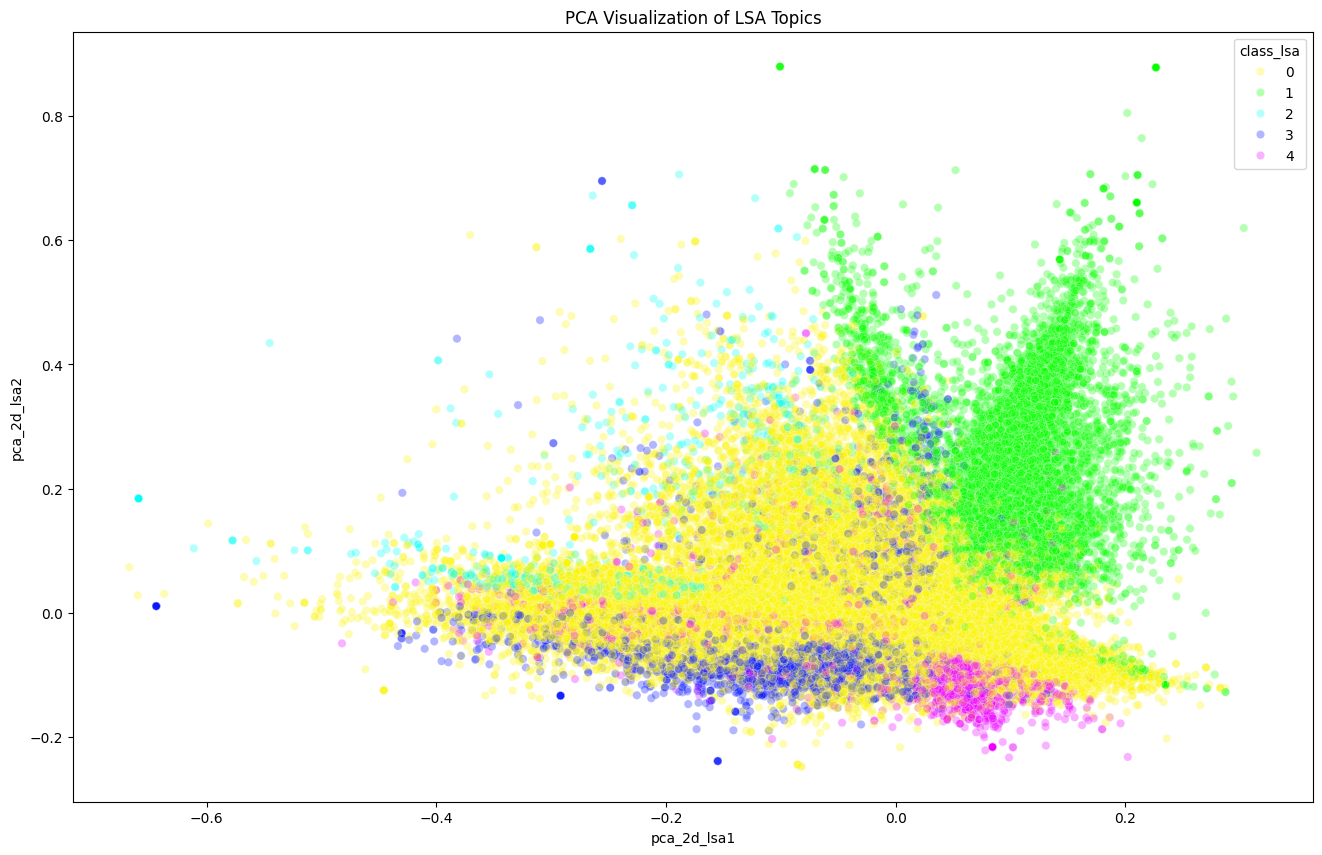

In [79]:
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(topic_distribution)
df['pca_2d_lsa1'] = pca_results[:, 0]
df['pca_2d_lsa2'] = pca_results[:, 1]
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca_2d_lsa1", y="pca_2d_lsa2",
    hue="class_lsa",
    palette=sns.color_palette("hsv", num_topics),
    data=df,
    legend="full",
    alpha=0.3
)
plt.title('PCA Visualization of LSA Topics')
plt.show()

#### Saving labelled data

In [80]:
df.to_csv('labelled_inquaries.csv', index=False)
print(df.head())

   sno                                            inquiry  class_kmeans  \
0    0  Hello folks, please help me a bit with the fol...             4   
1    1  is there any reason why my 'network manager' i...             0   
2    2  I installed the 64bit version of ubuntu and I ...             1   
3    3  Hello Does Ubuntu have somekind of register to...             1   
4    4  anyone else run into issues with cd/dvd burner...             4   

   class_lda  pca_2d_lda1  pca_2d_lda2  class_lsa  pca_2d_lsa1  pca_2d_lsa2  
0          3    -0.108240     0.437737          4     0.024693    -0.051617  
1          2     0.491780     0.114979          1     0.079864     0.101397  
2          2     0.314585    -0.171005          0    -0.053836    -0.009172  
3          2     0.207391     0.060456          0    -0.068189     0.169535  
4          3    -0.160618     0.602125          0    -0.006105    -0.042033  


### Step 2: Pre classification modelling Engineering

#### Loading and Observing labelled Data

In [81]:
df = pd.read_csv('labelled_inquaries.csv')

#### Vectorization and feature engineering

In [82]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', str(text))  # Remove all non-word characters
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Replace multiple spaces with a single space
    text = text.lower()  # Convert to lower case
    text = re.sub(r'^\s+|\s+?$', '', text)  # Remove leading and trailing spaces
    return text

In [83]:
df['inquiry'] = df['inquiry'].apply(preprocess_text)

In [84]:
stop_words = set(stopwords.words('english'))
df['inquiry'] = df['inquiry'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

### Method 1: Logistic Regression

In [86]:
def logisticRegression(label):
    X_train, X_test, y_train, y_test = train_test_split(df['inquiry'], df[label], test_size=0.2, random_state=42)
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(classification_report(y_test, y_pred))

#### Classification & Evaluation with Kmeans data

In [87]:
logisticRegression("class_kmeans")

Accuracy: 98.59%
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       873
           1       0.97      0.98      0.98      7126
           2       0.98      0.98      0.98      3449
           3       0.96      0.96      0.96      1794
           4       0.99      0.99      0.99     23911

    accuracy                           0.99     37153
   macro avg       0.98      0.98      0.98     37153
weighted avg       0.99      0.99      0.99     37153



#### Classification & Evaluation with LDA data

In [88]:
logisticRegression("class_lda")

Accuracy: 86.49%
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      8769
           1       0.86      0.85      0.86      7690
           2       0.87      0.89      0.88      9404
           3       0.89      0.89      0.89      7496
           4       0.81      0.74      0.78      3794

    accuracy                           0.86     37153
   macro avg       0.86      0.85      0.85     37153
weighted avg       0.86      0.86      0.86     37153



#### Classification & Evaluation with LSA dta

In [89]:
logisticRegression("class_lsa")

Accuracy: 93.74%
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     30113
           1       0.89      0.71      0.79      2958
           2       0.87      0.26      0.40       255
           3       0.93      0.84      0.88      1799
           4       0.92      0.74      0.82      2028

    accuracy                           0.94     37153
   macro avg       0.91      0.71      0.77     37153
weighted avg       0.94      0.94      0.93     37153



####

### Method 2: Convolution Neural Networks

In [93]:
def cnn(label):
    label_encoder = LabelEncoder()
    df[label] = label_encoder.fit_transform(df[label])
    X_train, X_test, y_train, y_test = train_test_split(df['inquiry'], df[label], test_size=0.2, random_state=42)
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    max_seq_length = max([len(x) for x in X_train_seq])
    X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
    X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_seq_length))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)
    loss, accuracy = model.evaluate(X_test_padded, y_test)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    y_pred = model.predict(X_test_padded)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = label_encoder.inverse_transform(y_test)
    y_pred = label_encoder.inverse_transform(y_pred)
    print(classification_report(y_test, y_pred))

#### Classification & Evaluation with Kmeans data

In [94]:
cnn("class_kmeans")

c:\Users\akash\My Folder\GenAI\Databricks-challenge2024-classifier\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 97s 25ms/step - accuracy: 0.8936 - loss: 0.3803 - val_accuracy: 0.9336 - val_loss: 0.2149
Epoch 2/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 95s 25ms/step - accuracy: 0.9422 - loss: 0.1935 - val_accuracy: 0.9383 - val_loss: 0.2201
Epoch 3/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 90s 24ms/step - accuracy: 0.9571 - loss: 0.1357 - val_accuracy: 0.9346 - val_loss: 0.2345
Epoch 4/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 91s 25ms/step - accuracy: 0.9704 - loss: 0.0878 - val_accuracy: 0.9313 - val_loss: 0.2820
Epoch 5/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 91s 24ms/step - accuracy: 0.9806 - loss: 0.0592 - val_accuracy: 0.9279 - val_loss: 0.3398
Epoch 6/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 90s 24ms/step - accuracy: 0.9855 - loss: 0.0437 - val_accuracy: 0.9281 - val_loss: 0.4315
Epoch 7/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 91s 24ms/step - accuracy: 0.9889 - loss: 0.0348 - val_accuracy: 0.9248 - val_loss: 0.4596
Epoch 8/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 99s 27ms/step - accuracy: 0.9906 -

#### Classification & Evaluation with LDA data

In [95]:
cnn("class_lda")

Epoch 1/10


c:\Users\akash\My Folder\GenAI\Databricks-challenge2024-classifier\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3716/3716 ━━━━━━━━━━━━━━━━━━━━ 97s 25ms/step - accuracy: 0.6674 - loss: 0.8536 - val_accuracy: 0.7916 - val_loss: 0.5537
Epoch 2/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 92s 25ms/step - accuracy: 0.8171 - loss: 0.4957 - val_accuracy: 0.7954 - val_loss: 0.5343
Epoch 3/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 91s 25ms/step - accuracy: 0.8542 - loss: 0.3952 - val_accuracy: 0.7971 - val_loss: 0.5584
Epoch 4/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 107s 29ms/step - accuracy: 0.8900 - loss: 0.3007 - val_accuracy: 0.7924 - val_loss: 0.6178
Epoch 5/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 108s 29ms/step - accuracy: 0.9197 - loss: 0.2238 - val_accuracy: 0.7911 - val_loss: 0.6955
Epoch 6/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 108s 29ms/step - accuracy: 0.9378 - loss: 0.1754 - val_accuracy: 0.7818 - val_loss: 0.8309
Epoch 7/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 0.9493 - loss: 0.1428 - val_accuracy: 0.7841 - val_loss: 0.9263
Epoch 8/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 110s 30ms/step - accuracy: 0.9592 - loss:

#### Classification & Evaluation with LSA data

In [96]:
cnn("class_lsa")

Epoch 1/10


c:\Users\akash\My Folder\GenAI\Databricks-challenge2024-classifier\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3716/3716 ━━━━━━━━━━━━━━━━━━━━ 116s 30ms/step - accuracy: 0.8801 - loss: 0.4005 - val_accuracy: 0.9101 - val_loss: 0.2666
Epoch 2/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 104s 28ms/step - accuracy: 0.9205 - loss: 0.2388 - val_accuracy: 0.9163 - val_loss: 0.2591
Epoch 3/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 0.9387 - loss: 0.1823 - val_accuracy: 0.9145 - val_loss: 0.2810
Epoch 4/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 0.9559 - loss: 0.1289 - val_accuracy: 0.9045 - val_loss: 0.3417
Epoch 5/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 108s 29ms/step - accuracy: 0.9683 - loss: 0.0920 - val_accuracy: 0.9072 - val_loss: 0.4194
Epoch 6/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 0.9771 - loss: 0.0673 - val_accuracy: 0.9048 - val_loss: 0.4913
Epoch 7/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 0.9820 - loss: 0.0535 - val_accuracy: 0.9035 - val_loss: 0.5917
Epoch 8/10
3716/3716 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 0.9846 - lo